# Set Up and Install Tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/tensorflow/models

In [ ]:
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim

In [4]:
!rm -rf /usr/local/lib/python3.10/dist-packages/tf_slim/data/tfexample_decoder.py

In [5]:
!cp /content/drive/MyDrive/Cse168Data/tfexample_decoder.py /usr/local/lib/python3.10/dist-packages/tf_slim/data/tfexample_decoder.py

In [ ]:
!pip install pycocotools

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

#Prepare Datasets

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8.tar.gz
# !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_800x1333_coco17_gpu-8.tar.gz

In [11]:
!tar -xzvf faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8.tar.gz
# /content/models/research/object_detection/dataset_tools/create_coco_tf_record.py

faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/
faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/checkpoint/
faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/checkpoint/ckpt-0.data-00000-of-00001
faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/checkpoint/checkpoint
faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/checkpoint/ckpt-0.index
faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/pipeline.config
faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/saved_model/
faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/saved_model/saved_model.pb
faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/saved_model/variables/
faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/saved_model/variables/variables.data-00000-of-00001
faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/saved_model/variables/variables.index


In [ ]:
!python /content/models/research/object_detection/dataset_tools/create_coco_tf_record.py \
      --logtostderr \
      --train_image_dir=/content/drive/MyDrive/Cse168Data/data/train  \
      --test_image_dir=/content/drive/MyDrive/Cse168Data/data/test \
      --val_image_dir=/content/drive/MyDrive/Cse168Data/data/validation \
      --train_annotations_file=/content/drive/MyDrive/Cse168Data/data/train/train.json \
      --test_annotations_file=/content/drive/MyDrive/Cse168Data/data/test/test.json \
      --val_annotations_file=/content/drive/MyDrive/Cse168Data/data/validation/validate.json \
      --testdev_annotations_file=/content/drive/MyDrive/Cse168Data/data/test/test.json \
      --output_dir=/content/annotations

In [13]:
min_dim = 600
max_dim = 601
finetune = '/content/faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/checkpoint/ckpt-0'
num_steps = 100
train_record = '/content/annotations/coco_train.record*'
test_record = '/content/annotations/coco_test.record*'
label_map = '/content/drive/MyDrive/Cse168Data/data/labelmap.pbtxt'
batch_size = 2
num_classes = 4

In [16]:
import re

with open('/content/faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/pipeline.config') as f:
    s = f.read()

with open('/content/faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/pipeline.config', 'w') as f:
    # img_size
    s = re.sub('min_dimension: [0-9]+', 'min_dimension: {}'.format(min_dim), s)
    s = re.sub('max_dimension: [0-9]+', 'max_dimension: {}'.format(max_dim), s)
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"', 'fine_tune_checkpoint: "{}"'.format(finetune), s)
    # tfrecord files train and test
    s = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record), s)
    s = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record), s)
    # label_map_path
    s = re.sub('label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map), s)
    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+','batch_size: {}'.format(batch_size), s)
    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+', 'num_steps: {}'.format(num_steps), s)
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+','num_classes: {}'.format(num_classes), s)
    #fine-tune checkpoint type
    s = re.sub('fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)

    f.write(s)

In [ ]:
!nvidia-smi

In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)

In [ ]:
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py\
  --pipeline_config_path=/content/faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/pipeline.config \
  --num_train_steps=1000 \
  --model_dir=/content/training \
  --alsologtostderr

In [ ]:
!rm -rf /content/training

# Model Metrics



In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/training/train'
# %reload_ext tensorboard


# Test Model

In [ ]:
!python '/content/models/research/object_detection/exporter_main_v2.py' \
    --trained_checkpoint_dir '/content/training/' \
    --output_directory '/content/drive/MyDrive/Cse168Data/model_saved' \
    --pipeline_config_path '/content/faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/pipeline.config'

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf
from google.colab import files
import pathlib
import itertools
import random

import cv2

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

from object_detection.utils import config_util
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [29]:
def load_image_into_numpy_array(path):
  img = cv2.imread(path)
  return np.array(img)

In [30]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [ ]:
filenames = list(pathlib.Path('/content/training/').glob('*.index'))

filenames.sort()
print(filenames)

model_dir = '/content/training/'

configs = config_util.get_configs_from_pipeline_file("/content/faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8/pipeline.config")
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [32]:
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

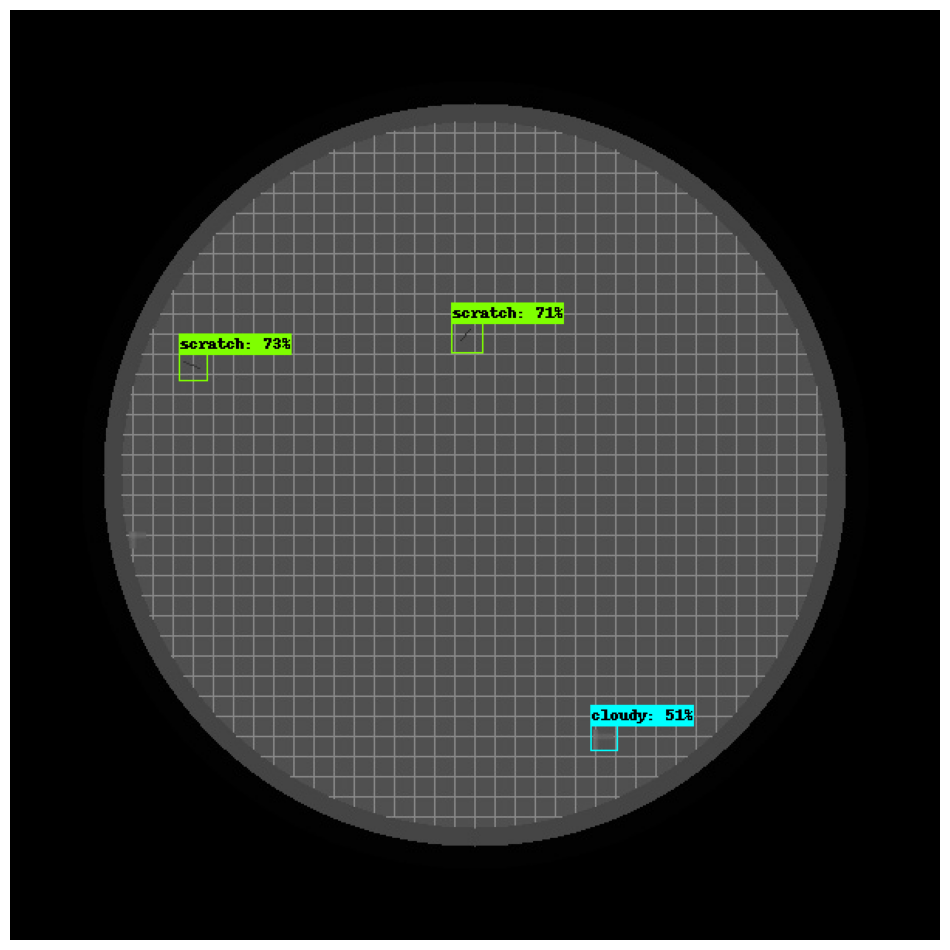

In [37]:
TEST_IMAGE_PATHS = glob.glob('/content/drive/MyDrive/Cse168Data/data/test/*.jpg')
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      line_thickness=1,
      min_score_thresh=.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.axis("off")
plt.show()

# Save Work

In [ ]:
!cp -r /content/annotations/ /content/drive/MyDrive/Cse168Data/data/

In [ ]:
!cp /usr/local/lib/python3.10/dist-packages/tf_slim/data/tfexample_decoder.py /content/drive/MyDrive/Cse168Data/

In [ ]:
# import re
# with open(r'/content/models/research/object_detection/packages/tf2/setup.py', 'r') as file :
#   s = file.read()

# with open('/content/models/research/setup.py', 'w') as file:
#   s = re.sub('\'tf-models-official >= 2.5.1',
#              'tf-models-official >= 2.8.0', s)
#   file.write(s)